In [1]:
import numpy as np
import os
import six.moves.urllib as urllib
import sys
import tarfile
import tensorflow as tf
import zipfile

from distutils.version import StrictVersion
from collections import defaultdict
from io import StringIO
%matplotlib inline
import matplotlib.pyplot as plt
from PIL import Image

sys.path.append('/home/chaitanya_anand/Work/models/research/')
from object_detection.utils import ops as utils_ops

if StrictVersion(tf.__version__) < StrictVersion('1.12.0'):
  raise ImportError('Please upgrade your TensorFlow installation to v1.12.*.')


/usr/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:519: FutureWarning: Passing (type, 1) or '1type' as a synonym of 

In [2]:
sys.path.append('/home/chaitanya_anand/Work/models/research/object_detection')
from utils import label_map_util

from utils import visualization_utils as vis_util

/home/chaitanya_anand/Work/models/research/object_detection/utils/visualization_utils.py:29: UserWarning: matplotlib.pyplot as already been imported, this call will have no effect.
  import matplotlib; matplotlib.use('Agg')  # pylint: disable=multiple-statements


In [3]:
MODEL_NAME = 'inference_graph'
PATH_TO_FROZEN_GRAPH = MODEL_NAME + '/frozen_inference_graph.pb'
PATH_TO_LABELS = 'training/labelMap.pbtxt'

In [4]:
detection_graph = tf.Graph()
with detection_graph.as_default():
  od_graph_def = tf.GraphDef()
  with tf.gfile.GFile(PATH_TO_FROZEN_GRAPH, 'rb') as fid:
    serialized_graph = fid.read()
    od_graph_def.ParseFromString(serialized_graph)
    tf.import_graph_def(od_graph_def, name='')

In [5]:
category_index = label_map_util.create_category_index_from_labelmap(PATH_TO_LABELS, use_display_name=True)

W0827 21:21:06.575534 140374631761536 deprecation_wrapper.py:119] From /home/chaitanya_anand/Work/models/research/object_detection/utils/label_map_util.py:137: The name tf.gfile.GFile is deprecated. Please use tf.io.gfile.GFile instead.



In [6]:
def load_image_into_numpy_array(image):
  (im_width, im_height) = image.size
  return np.array(image.getdata()).reshape(
      (im_height, im_width, 3)).astype(np.uint8)

In [11]:
PATH_TO_TEST_IMAGES_DIR = 'images/test'
TEST_IMAGE_PATHS = [ os.path.join(PATH_TO_TEST_IMAGES_DIR, 'image{}.png'.format(i)) for i in range(1, 4) ]

IMAGE_SIZE = (12, 8)

In [12]:
def run_inference_for_single_image(image, graph):
  with graph.as_default():
    with tf.Session() as sess:
      ops = tf.get_default_graph().get_operations()
      all_tensor_names = {output.name for op in ops for output in op.outputs}
      tensor_dict = {}
      for key in [
          'num_detections', 'detection_boxes', 'detection_scores',
          'detection_classes', 'detection_masks'
      ]:
        tensor_name = key + ':0'
        if tensor_name in all_tensor_names:
          tensor_dict[key] = tf.get_default_graph().get_tensor_by_name(
              tensor_name)
      if 'detection_masks' in tensor_dict:
        detection_boxes = tf.squeeze(tensor_dict['detection_boxes'], [0])
        detection_masks = tf.squeeze(tensor_dict['detection_masks'], [0])
        real_num_detection = tf.cast(tensor_dict['num_detections'][0], tf.int32)
        detection_boxes = tf.slice(detection_boxes, [0, 0], [real_num_detection, -1])
        detection_masks = tf.slice(detection_masks, [0, 0, 0], [real_num_detection, -1, -1])
        detection_masks_reframed = utils_ops.reframe_box_masks_to_image_masks(
            detection_masks, detection_boxes, image.shape[1], image.shape[2])
        detection_masks_reframed = tf.cast(
            tf.greater(detection_masks_reframed, 0.5), tf.uint8)
        tensor_dict['detection_masks'] = tf.expand_dims(
            detection_masks_reframed, 0)
      image_tensor = tf.get_default_graph().get_tensor_by_name('image_tensor:0')

      output_dict = sess.run(tensor_dict,
                             feed_dict={image_tensor: image})

      output_dict['num_detections'] = int(output_dict['num_detections'][0])
      output_dict['detection_classes'] = output_dict[
          'detection_classes'][0].astype(np.int64)
      output_dict['detection_boxes'] = output_dict['detection_boxes'][0]
      output_dict['detection_scores'] = output_dict['detection_scores'][0]
      if 'detection_masks' in output_dict:
        output_dict['detection_masks'] = output_dict['detection_masks'][0]
  return output_dict

images/test/image1.png
[9.89460230e-01 9.09327388e-01 8.09979737e-01 6.13700688e-01
 1.92235455e-01 1.66963026e-01 1.63558781e-01 1.46877617e-01
 6.16654381e-02 5.13754301e-02 3.91686708e-02 2.74205562e-02
 2.73299627e-02 2.53600460e-02 1.33393239e-02 1.15477545e-02
 8.52495711e-03 2.98461388e-03 2.34340224e-03 1.95246271e-03
 1.90992153e-03 1.37932831e-03 1.04055018e-03 8.03471892e-04
 6.70373032e-04 6.42996165e-04 6.32985786e-04 6.28056354e-04
 5.71851619e-04 5.08448691e-04 4.89791506e-04 4.79532697e-04
 4.68751474e-04 4.64641722e-04 4.64621553e-04 4.62222612e-04
 4.15712857e-04 4.13462840e-04 3.93878989e-04 3.90926056e-04
 3.78335913e-04 3.69920424e-04 3.60110367e-04 3.40382714e-04
 3.39275139e-04 3.29912815e-04 3.21641128e-04 3.12186923e-04
 3.04601534e-04 3.01444437e-04 2.96099985e-04 2.93862715e-04
 2.93824298e-04 2.83898378e-04 2.78526655e-04 2.72149977e-04
 2.68375647e-04 2.64164875e-04 2.63797469e-04 2.62808142e-04
 2.58294283e-04 2.57135835e-04 2.51566526e-04 2.51338613e-04
 

[5.8286309e-01 4.2253208e-01 3.8738373e-01 3.4780002e-01 2.1326217e-01
 1.9780307e-01 1.3545881e-01 9.6821338e-02 7.2412997e-02 3.9944585e-02
 2.9583577e-02 2.8152114e-02 1.1714063e-02 1.0211774e-02 7.6912898e-03
 6.5273796e-03 6.1384258e-03 4.9990276e-03 4.8971074e-03 4.6823760e-03
 4.5557567e-03 4.5396141e-03 4.4386615e-03 4.3172664e-03 4.1688532e-03
 4.1299080e-03 3.7283080e-03 3.7088860e-03 3.5611051e-03 3.4362099e-03
 3.4251891e-03 3.1533805e-03 3.1065131e-03 3.0601206e-03 2.9150140e-03
 2.8166857e-03 2.7042825e-03 2.6733696e-03 2.5524932e-03 2.5369858e-03
 2.5200332e-03 2.5132960e-03 2.4654898e-03 2.3730367e-03 2.3404900e-03
 2.3078325e-03 2.2592486e-03 2.1273142e-03 2.1229114e-03 2.1132005e-03
 2.0917363e-03 2.0873314e-03 2.0025743e-03 1.8743793e-03 1.8712112e-03
 1.8591997e-03 1.8518984e-03 1.7612624e-03 1.7305278e-03 1.6977548e-03
 1.6729399e-03 1.6614976e-03 1.6274620e-03 1.6264784e-03 1.6142380e-03
 1.5783554e-03 1.4992884e-03 1.4834476e-03 1.4545161e-03 1.4056986e-03
 1.391

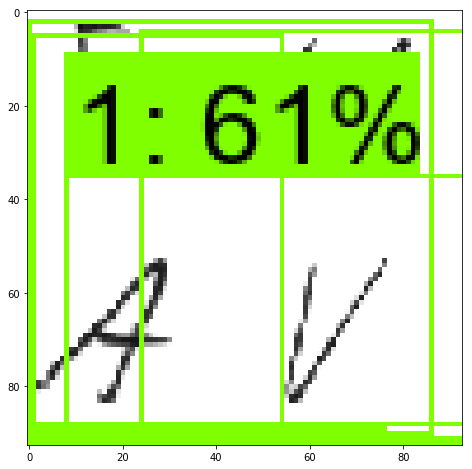

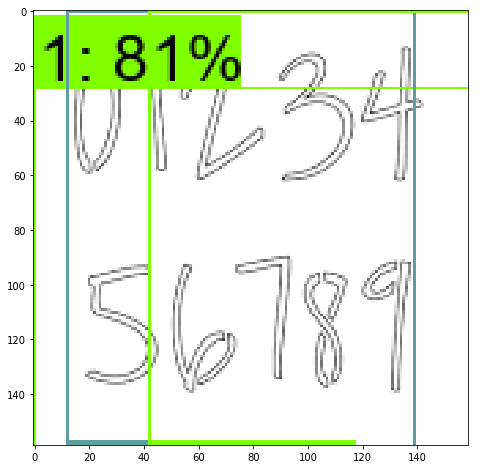

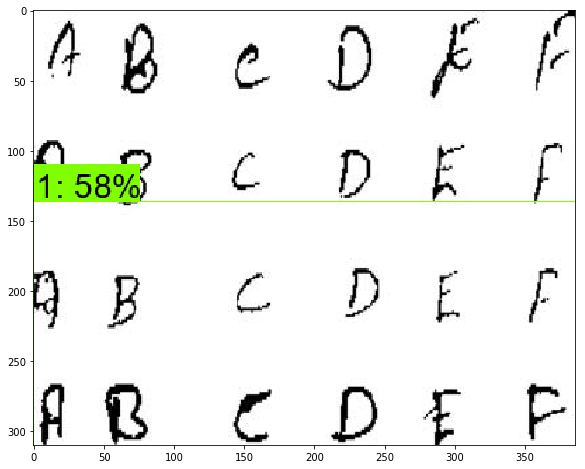

In [14]:
for image_path in TEST_IMAGE_PATHS:
  print(image_path)
  image = Image.open(image_path)
  image_np = load_image_into_numpy_array(image)
  image_np_expanded = np.expand_dims(image_np, axis=0)
  output_dict = run_inference_for_single_image(image_np_expanded, detection_graph)
  print(output_dict['detection_scores'])
  vis_util.visualize_boxes_and_labels_on_image_array(
      image_np,
      output_dict['detection_boxes'],
      output_dict['detection_classes'],
      output_dict['detection_scores'],
      category_index,
      instance_masks=output_dict.get('detection_masks'),
      use_normalized_coordinates=True,
      line_thickness=1)
  plt.figure(figsize=IMAGE_SIZE)
  plt.imshow(image_np)
plt.show()